<a href="https://colab.research.google.com/github/Belzinha0402/Dio-Java-B-sico/blob/main/labs/lab2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Laboratório 2

Estatísticas, histogramas, contraste e composições de imagens no GEE


Objetivos:

1. Operações para calcular estatísticas dos valores dos pixels nas bandas de um raster e gerar gráficos de suas distribuições
2. Extrair valores de um pixel em uma imagem
3. Ajustar o contraste de uma imagem adicionada ao mapa e como formar composições coloridas com as bandas dos dados


## Introdução


In [43]:
import ee
import geemap.geemap as geemap
import matplotlib.pyplot as plt

In [44]:
# Ref: https://developers.google.com/earth-engine/apidocs/ee-authenticate
# Para inicializar a sessão para execução insira o id do projeto em ee.Initialize().
ee.Authenticate()
ee.Initialize(project='ee-leonardogodoy')

In [45]:
%matplotlib inline

## Desenvolvimento


Definir um ponto na cidade de São Paulo


In [46]:
lat, lon = -23.5546721, -46.7318389
poli_usp_point = ee.Geometry.Point(coords=[lon, lat], proj="EPSG:4326")

Definir um bbox na cidade de São Paulo

Observação: Fazer a seleção de um polígono retangular pequeno na área de São Paulo para que o processamento fique mais rápido.


In [47]:
sao_paulo_box = ee.Geometry.BBox(
    west=-46.81,
    south=-23.5,
    east=-46.654,
    north=-23.7,
)

### Preparando a coleção


Importar a coleção de images “Sentinel-2 MSI: MultiSpectral Instrument, Level-1C”


In [48]:
colecao_sentinel2 = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")
# Veja a documentação em: https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR_HARMONIZED

Selecionar apenas as imagens que contém o ponto selecionado


In [49]:
img_histograma = colecao_sentinel2.filterBounds(poli_usp_point)

Filtrar apenas imagens em um intervalo de datas desejado


In [50]:
start_date = ee.Date("2021-01-01")
end_date = ee.Date("2022-01-01")
img_histograma = img_histograma.filterDate(start_date, end_date)

Filtrar apenas as imagens com menos de 20% de cobertura de nuvens


In [51]:
img_histograma = img_histograma.filterMetadata(
    "CLOUDY_PIXEL_PERCENTAGE", "less_than", 20
)

Selecionar apenas a primeira imagem da coleção, pois precisamos de somente uma imagem para o restante da prática


In [52]:
img_histograma = img_histograma.first()

Selecionar somente algumas das bandas para análise.


In [53]:
img_histograma = img_histograma.select(["B2", "B4", "B3", "B5"])

Fazer um recorte (_clip_) da imagem para a área o retângulo que definimos anteriormente


In [54]:
img_histograma = img_histograma.clip(sao_paulo_box)

Criar um mapa através do `geemap`, biblioteca de visualização de dados geoespaciais


In [55]:
my_map = geemap.Map(center=[lat, lon], zoom=11)

Vamos adicionar uma banda da imagem ao mapa para visualização, isso gerará uma imagem monocromática


In [56]:
my_map.addLayer(
    ee_object=img_histograma.select("B2"),
    vis_params={},
    name="Recorte São Paulo - Banda B2",
)
# O segundo parâmetro da função, que ajusta a visualização, está vazio para manter os valores do padrão.
# O terceiro parâmetro é o título para a camada que é criada no mapa pela função.

Para visualizar o mapa


In [57]:
my_map

Map(center=[-23.5546721, -46.7318389], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=…

Podemos checar o valor da banda B2 para o ponto que criarmos anteriormente:


In [58]:
value = img_histograma.reduceRegion(
    reducer=ee.Reducer.mean(), geometry=poli_usp_point, scale=10
)

print("Valor de cada banda no ponto selecionado:")
print(value.getInfo())

Valor de cada banda no ponto selecionado:
{'B2': 1310, 'B3': 1622, 'B4': 1802, 'B5': 1831}


### Estatísticas dos dados de uma imagem no GEE


Calcular o desvio padrão dos valores dos pixels de uma imagem com o `Reducer.stdDev()`


In [59]:
dp_pixels_bandas = img_histograma.reduceRegion(
    reducer=ee.Reducer.stdDev(), maxPixels=1e9
)
print("Desvio Padrão: ", dp_pixels_bandas.getInfo())

# OBS: O parâmetro maxPixels é necessário para evitar erros de memória.

Desvio Padrão:  {'B2': 452.4358728896109, 'B3': 460.949712256228, 'B4': 550.2541603036304, 'B5': 482.12187257558435}


Calcular a média dos valores dos pixels de uma imagem com o `Reducer.mean()`


In [18]:
media_pixels_bandas = img_histograma.reduceRegion(
    reducer=ee.Reducer.mean(), maxPixels=1e9
)
print("Média: ", media_pixels_bandas.getInfo())

Média:  {'B2': 997.225899941477, 'B3': 1219.2828016538658, 'B4': 1306.9414521449135}


Calcular a variância dos valores dos pixels de uma imagem com o `Reducer.variance()`


In [19]:
variancia_pixels_bandas = img_histograma.reduceRegion(
    reducer=ee.Reducer.variance(), maxPixels=1e9
)
print("Variância: ", variancia_pixels_bandas.getInfo())

Variância:  {'B2': 425937.7721403709, 'B3': 428602.5415608858, 'B4': 583302.2929832203}


### Escalonando os valores da imagem


Os valores das coleções do Sentinel-2 disponíveis no GEE são os valores da reflectância multiplicados por 10.000 (dez mil).
Precisamos dividir os valores por 10.000 para obter os valores de reflectância, que devem obrigatoriamente estar entre 0 e 1.


In [20]:
img_histograma_nao_escalonada = img_histograma.divide(ee.Image.constant(10000))

### Gerando histogramas


Vamos gerar histogramas para visualizar a distribuição dos valores dos pixels de uma imagem.
Porém antes de gerar o histograma, vamos recalcular os valores das estatísticas para a imagem escalonada.


In [21]:
dp_pixels_bandas = img_histograma_nao_escalonada.reduceRegion(
    reducer=ee.Reducer.stdDev(), maxPixels=1e9
)
print("Desvio Padrão Imagem Não Escalonada: ")
for key, value in dp_pixels_bandas.getInfo().items():
    print(f"\tBanda {key}: {value:.4f}")

Desvio Padrão Imagem Não Escalonada: 
	Banda B2: 0.0653
	Banda B3: 0.0655
	Banda B4: 0.0764


In [22]:
media_pixels_bandas = img_histograma_nao_escalonada.reduceRegion(
    reducer=ee.Reducer.mean(), maxPixels=1e9
)
print("Média Imagem Não Escalonada: ")
for key, value in media_pixels_bandas.getInfo().items():
    print(f"\tBanda {key}: {value:.4f}")

Média Imagem Não Escalonada: 
	Banda B2: 0.0997
	Banda B3: 0.1219
	Banda B4: 0.1307


In [23]:
variancia_pixels_bandas = img_histograma_nao_escalonada.reduceRegion(
    reducer=ee.Reducer.variance(), maxPixels=1e9
)
print("Variância Imagem Não Escalonada: ")
for key, value in variancia_pixels_bandas.getInfo().items():
    print(f"\tBanda {key}: {value:.4f}")

Variância Imagem Não Escalonada: 
	Banda B2: 0.0043
	Banda B3: 0.0043
	Banda B4: 0.0058


Agora, para criação do histograma, vamos selecionar somente a banda B2 da imagem


In [25]:
banda_B2 = img_histograma_nao_escalonada.select("B2")

Utilizamos o `ee.Reducer.histogram()` para gerar o histograma.


In [26]:
# maxBuckets: é o número máximo de buckets (colunas) no histograma. Esse valor deve ser uma potência de 2, caso não seja, será arredondado para a potência de 2 mais próxima.
# minBucketWidth: é a largura mínima de cada bucket (coluna) do histograma.
# maxPixels: é o número máximo de pixels que serão usados para calcular o histograma.
histograma_b2 = banda_B2.reduceRegion(
    reducer=ee.Reducer.histogram(maxBuckets=1000, minBucketWidth=0.00001), maxPixels=1e9
).getInfo()["B2"]

A variável `histograma` é um dicionário, e dela vamos extrair as listas necessárias para realizar o gráfico


In [27]:
frequencias_b2 = histograma_b2["histogram"]
bins_b2 = histograma_b2["bucketMeans"]

Finalmente, vamos plotar o histograma com o módulo `matplotlib.pyplot` (ou `plt`) que foi importado no início do notebook.


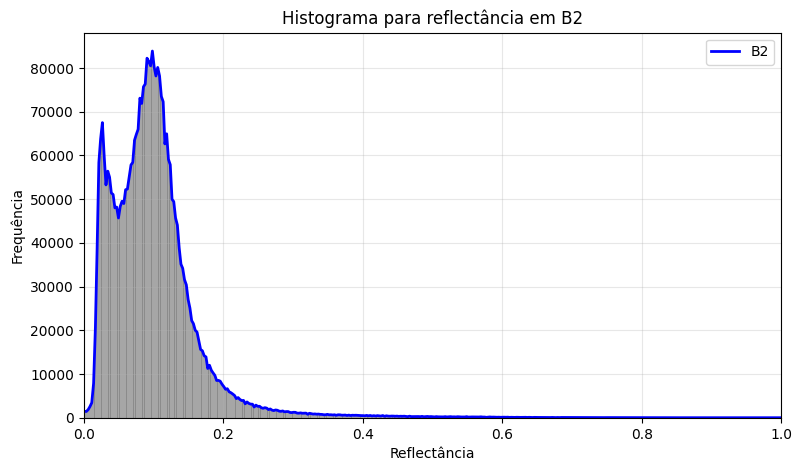

In [28]:
fig, ax = plt.subplots(figsize=(9, 5))
ax.bar(bins_b2, frequencias_b2, width=bins_b2[1] - bins_b2[0], color="gray", alpha=0.7)
ax.plot(bins_b2, frequencias_b2, color="blue", linewidth=2, alpha=1, label="B2")
ax.set_title("Histograma para reflectância em B2")
ax.set_xlabel("Reflectância")
ax.set_ylabel("Frequência")
ax.set_xlim(0, 1)
ax.grid(True, alpha=0.3)
ax.legend()
plt.show()

### Gerando histograma para várias bandas


Primeiro vamos obter o histograma para todas as bandas da imagem de uma vez só.
Para isso, basta alterar a imagem que estamos utilizando para a imagem original (sem filtrar a banda B2).


In [29]:
histograma = img_histograma_nao_escalonada.reduceRegion(
    reducer=ee.Reducer.histogram(maxBuckets=2**9, minBucketWidth=0.001), maxPixels=1e9
).getInfo()

Utilizar um `for` _loop_ do Python para gerar diferentes histogramas para cada banda da imagem.


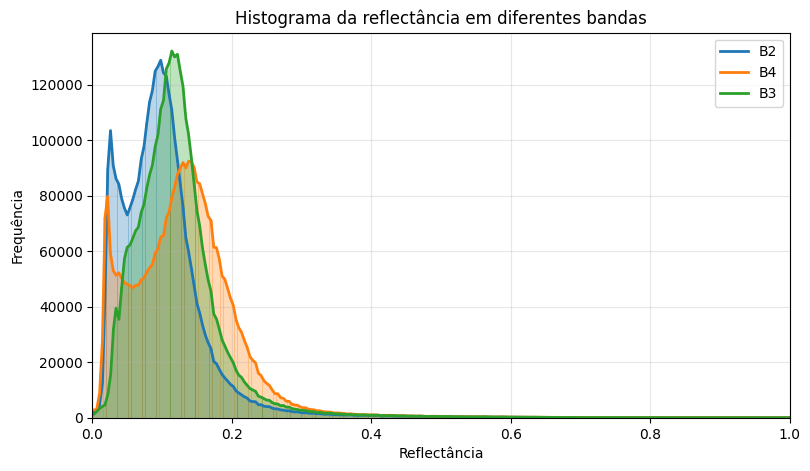

In [30]:
fig, ax = plt.subplots(figsize=(9, 5))

for i, banda in enumerate(["B2", "B4", "B3"]):
    frequencias = histograma[banda]["histogram"]
    bins = histograma[banda]["bucketMeans"]

    ax.bar(bins, frequencias, width=bins[1] - bins[0], alpha=0.3)
    ax.plot(bins, frequencias, linewidth=2, label=banda)
    ax.set_title(f"Histograma da reflectância em diferentes bandas")
    ax.set_xlabel("Reflectância")
    ax.set_ylabel("Frequência")
    ax.set_xlim([0, 1])

plt.grid(True, alpha=0.3)
plt.legend(loc="upper right")
plt.show()

### Ajustando o contraste de uma imagem


A imagem que visualizamos anteriormente está com o contraste muito baixo, pois foi adicionada com os valores padrões.
Para ajustar, podemos seguir dois caminhos:

1. Editar o parâmetro "Range" no `control_layer` do mapa, que fica no canto superior direito do mapa
2. Remover o _layer_ e adicionar novamente com os parâmetros desejados

Vamos seguir o caminho 2 na célula a seguir, porém o resultado é o mesmo.


In [31]:
# Remove a camada que tenha o nome "Recorte São Paulo - Banda B2"
# TODO: deve ter uma forma melhor de fazer isso sem usar comprehension list
my_map.remove_layer(
    x for x in my_map.layers if x.name == "Recorte São Paulo - Banda B2"
)

# Define parâmetros de visualização
vis_params = {
    "bands": ["B2"],
    "min": 0,
    "max": 1,
    "gamma": 1,
}

# Adiciona a imagem novamente ao mapa
my_map.addLayer(
    ee_object=img_histograma_nao_escalonada.select("B2"),
    vis_params=vis_params,
    name="Recorte São Paulo - Banda B2",
)

Finalmente, para visualizar o mapa com o contraste ajustado, basta executar a célula abaixo.


In [32]:
my_map

Map(bottom=149107.0, center=[-23.653329937833263, -46.9720458984375], controls=(WidgetControl(options=['positi…

### Composição colorida com ajuste de contraste simples


Eu sei que vocês estão pensando: "Mas eu quero ver uma imagem colorida, não uma imagem em tons de cinza!". Para isso vamos utilizar o método `addLayer()` novamente, porém agora vamos adicionar as bandas RGB da imagem.

As bandas RGB são as bandas 4, 3 e 2, respectivamente. Essa informação é retirada da documentação da coleção Sentinel-2 no GEE: https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR


In [33]:
vis_params = {
    "bands": ["B4", "B3", "B2"],
    "min": 0.04,
    "max": 0.4,
    "gamma": 1,
}
# Para escolher os valores de “min” e “max”, uma alternativa é utilizar os
# histogramas gerados anteriormente e escolher visualmente os pontos de corte

my_map.addLayer(
    ee_object=img_histograma_nao_escalonada.select(["B4", "B3", "B2"]),
    vis_params=vis_params,
    name="RGB",
)

In [34]:
my_map

Map(bottom=148974.0, center=[-23.48528996422356, -46.55044555664063], controls=(WidgetControl(options=['positi…

## Indo além


### Composição colorida com ajustes de contraste individuais


É possível fazer um mapeamento mais preciso de máximos e mínimos para cada banda, e assim ajustar de forma mais apropriada o contraste da imagem que será exibida na interface do GEE.

Além disso, vamos utilizar os histogramas que geramos anteriormente para definir os valores de máximos e mínimos para cada banda de forma automática.


Para começar, vamos calcular os valores de máximos para exibição de cada banda.
Vamos definir que o valor máximo de cada banda será a média mais uma vez o desvio padrão.


In [35]:
max_intervalos = []

media_values = media_pixels_bandas.getInfo().values()
dp_values = dp_pixels_bandas.getInfo().values()

for mean, dp in zip(media_values, dp_values):
    max_intervalos.append(mean + 2.5 * dp)

# Obs.: A função zip() retorna um iterador de tuplas, onde a i-ésima tupla contém
# o i-ésimo elemento de cada um dos argumentos sequenciais ou iteráveis.

max_intervalos

[0.26288236064478987, 0.2855976384690741, 0.32162971893353404]

Também precisamos definir os valores mínimos para cada banda.
Apenas para nos familiarizarmos com a sintaxe, dessa vez vamos evitar utilizar o `for` _loop_ do Python, em vez disso, vamos utilizar compreensão de listas (_list comprehension_).
Note que o resultado é o mesmo, apesar de ser um pouco mais difícil de ler, mas é uma forma de escrever código mais "pythônica".


In [36]:
min_intervalos = [
    mean - 2.5 * dp
    for mean, dp in zip(
        media_pixels_bandas.getInfo().values(), dp_pixels_bandas.getInfo().values()
    )
]
min_intervalos

[-0.06343718065649975, -0.041741078138308255, -0.06024142850456904]

Agora adicionamos a imagem ao mapa com os valores de máximos e mínimos definidos para cada banda.


In [37]:
vis_params = {
    "bands": ["B4", "B3", "B2"],
    "min": min_intervalos,
    "max": max_intervalos,
    "gamma": 1.4,
}

my_map.addLayer(
    ee_object=img_histograma_nao_escalonada.select(["B4", "B3", "B2"]),
    vis_params=vis_params,
    name="RGB advanced",
)

E finalmente podemos visualizar o mapa com a imagem colorida e com o contraste ajustado.


In [38]:
my_map

Map(bottom=148997.0, center=[-23.51488561753448, -46.325225830078125], controls=(WidgetControl(options=['posit…

## Atividade


Assim como no laboratório anterior, preencha os campos abaixo e submeta este _notebook_ para avaliação.


In [71]:
p1 = "1 - Qual o seu número USP?"
r1 = int(14610431)  # preencha com um número inteiro, ex: int(12345678)

p2 = "2 - Qual foi o valor médio de pixel na banda 2?"
r2 = int(997)  # preencha com um número inteiro, ex: int(12345678)

p3 = "3 - Calcule o desvio padrão da banda 5."
r3 = float(482)  # preencha com um número real

p4 = "4 - O que a banda 5 representa no conjunto de dados Sentinel-2? (ver a documentação)"
r4 = str("Red Edge 1; 703,9 nm (S2A) / 703,8 nm (S2B)")  # preencha com um número inteiro

Não altere a célula abaixo, apenas execute-a para carregar o formulário de submissão.


In [72]:
MY_FINAL_RESULT = {
    "p1": r1,
    "p2": r2,
    "p3": r3,
    "p4": r4,
}

MY_FINAL_RESULT

{'p1': 14610431,
 'p2': 997,
 'p3': 482.0,
 'p4': 'Red Edge 1; 703,9 nm (S2A) / 703,8 nm (S2B)'}